In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcol
from tqdm.notebook import tqdm_notebook as tqdm

In [2]:
class KMeans:
    def __init__(self, k:int, max_iter:int=10):
        self.k = k
        self.max_iter = max_iter
        
    def initialize(self, X):
        self.N, self.d = X.shape
        shuffled = np.copy(X)
        np.random.seed(0)
        np.random.shuffle(shuffled)
        self.centroids = shuffled[:self.k]
        self.assignment = np.zeros(self.N)
        
    def e_step(self, X):
        for i in range(self.N):
            x = X[i]
            scores = []
            for k in range(self.k):
                scores.append(np.linalg.norm(x - self.centroids[k]))
            self.assignment[i] = np.argmin(scores)
            
    def m_step(self, X):
        for k in range(self.k):
            ind_k = np.where(self.assignment == k)
            X_k = X[ind_k]
            self.centroids[k] = np.mean(X_k, axis=0)

    def fit(self, X):
        self.initialize(X)
        for _ in tqdm(range(self.max_iter),desc='K MEANS CLUSTERING: k='+str(self.k)):
            self.e_step(X)
            self.m_step(X)
        return self.centroids, self.predict(X)
            
    def predict(self, X):
        if(len(X.shape) == 1):
            X = np.array([X])
        N, _ = X.shape
        assignment = np.zeros(N,dtype=np.uint32)
        for i in range(N):
            x = X[i]
            scores = []
            for k in range(self.k):
                scores.append(np.linalg.norm(x - self.centroids[k]))
            assignment[i] = np.argmin(scores)
        return assignment

In [3]:
class GMM:
    def __init__(self, k:int, max_iter:int =5, max_k_iter:int =10):
        self.k = k
        self.max_iter = max_iter 
        self.max_k_iter = max_iter

    def initialize(self, X):
        # theta = [Mu, Sigma, Pi]
        n, d = X.shape
        ##################################################
        # USE K Means Engine to initialise (The M0 Step) #
        ##################################################
        kmeans = KMeans(k=self.k, max_iter= self.max_k_iter)
        centroids, assignment = kmeans.fit(X)
        self.mu = np.array(centroids)
        self.sigma = np.array([ np.cov(X.T) for _ in range(self.k) ])
        self.gamma = np.zeros((n,self.k))
        for i in range(n):
            self.gamma[i][assignment[i]] = 1
        self.pi = np.mean(self.gamma, axis=0)
                

    def gaussian(x: np.ndarray, mu: np.ndarray, sigma: np.ndarray):
        idvs = len(x)
        norm_factor = (2*np.pi)**idvs

        norm_factor *= np.linalg.det(sigma)
        norm_factor = 1.0/np.sqrt(norm_factor)

        x_mu = np.matrix(x-mu)

        rs = norm_factor*np.exp(-0.5*x_mu*np.linalg.pinv(sigma)*x_mu.T)
        return rs

    # E-Step: 
    def e_step(self, X):
        n,d = X.shape
        for i in range(n):
            x = X[i]
            p_x = 0.
            vec = []
            for k in range(self.k):
                p_xk = self.pi[k] * (GMM.gaussian(x, self.mu[k], self.sigma[k]))
                vec.append(p_xk.item())
                p_x += p_xk
            self.gamma[i] = (np.array(vec))*1.0/p_x
        self.pi = np.mean(self.gamma, axis=0)

    # M-Step: update meu and sigma holding phi and weights constant
    def m_step(self, X):
        # n,d = X.shape
        # for k in self.k:
        #     _mu_k_new = np.zeros(d);
        #     for i in range(n):
        #         _mu_k_new += self.gamma[i][k]*X[i]
        #     _mu_k_new /= self.gamma[:,k].sum()
        #     self.mu[k] = _mu_k_new
            # self.sigma[k] = np.cov(X.T,aweights=(weight/total_weight).flatten(), bias=True)
        for i in range(self.k):
            weight = self.gamma[:, [i]]
            total_weight = weight.sum()

            self.mu[i] = (X * weight).sum(axis=0) / total_weight
            self.sigma[i] = np.cov(X.T,aweights=(weight/total_weight).flatten(), bias=True)

    # responsible for clustering the data points correctly
    def fit(self, X):
        # initialise parameters like weights, phi, meu, sigma of all Gaussians in dataset X
        self.initialize(X)
        for iteration in tqdm(range(self.max_iter),desc='GMM (EM): k='+str(self.k)):
            # iterate to update the value of P(Xi/Ci=j) and (phi)k
            self.e_step(X)
            # iterate to update the value of meu and sigma as the clusters shift
            self.m_step(X)
    
    # predict function 
    def predict(self, X):
        n,d = np.array(X).shape
        gamma = np.zeros((n,self.k))
        for i in range(n):
            x = X[i]
            p_x = 0.
            vec = []
            for k in range(self.k):
                p_xk = self.pi[k] * (GMM.gaussian(x, self.mu[k], self.sigma[k]))
                vec.append(p_xk.item())
                p_x += p_xk
            gamma[i] = (np.array(vec))*1.0/p_x
        # self.pi = np.mean(self.gamma, axis=0)
        return np.argmax(gamma, axis=1)
        weights = self.predict_proba(X)
        # datapoint belongs to cluster with maximum probability
        # returns this value
        return np.argmax(weights, axis=1)
    
    def score(self, x, ret_gamma: bool = False):
        # x is d-dimensional single input feature vector
        if(ret_gamma):
            gamma = np.zeros(self.k)
            vec = []
        p_x = 0.
        for k in range(self.k):
            p_xk = self.pi[k] * (GMM.gaussian(x, self.mu[k], self.sigma[k]))
            if(ret_gamma):
                vec.append(p_xk.item())
            p_x += p_xk.item()
        if(ret_gamma):
            gamma = (np.array(vec))*1.0/p_x
            return p_x, gamma
        return p_x
    
    def plot_contour(self, fig, ax, _range, _input, color='red'):
        N, _, d = _input.shape
        if(d != 2):
            print("Can't plot for input not 2d")
            return None
        Z = np.empty((self.k,N,N))
        print("Plotting contours...")
        for k in tqdm(range(0,self.k)):
            for i in range(N):
                for j in range(N):
                    Z[k][i][j] = GMM.gaussian(_input[i][j], self.mu[k], self.sigma[k])
            ax.contour(_input[:,:,0], _input[:,:,1], Z[k], colors=color, levels=np.arange(0.2, 2.0, 0.5))
        print("Done")

In [4]:
import csv
X = []
Y = []
with open("6/train.txt") as f:
    reader = csv.reader(f)
    for row in reader:
        X.append([float(row[0]), float(row[1])])
        Y.append(int(row[2]))

df = pd.DataFrame(X, columns = ['x', 'y'])
df_norm = (df - df.mean()) / (df.std())
df_norm.head()

,x,y
0,-1.410683,1.139554
1,-0.967992,-0.830796
2,-1.451904,0.984208
3,-1.431584,1.302424
4,-1.080914,1.511558


In [5]:
Y = np.array(Y)
X = df_norm.to_numpy()
ind1 = np.where(Y == 1)
ind2 = np.where(Y == 2)

X1 = X[ind1]
X2 = X[ind2]

(array([   0,    1,    2, ..., 1247, 1248, 1249], dtype=int64),)
(array([1250, 1251, 1252, ..., 2497, 2498, 2499], dtype=int64),)


In [6]:
gmm1 = GMM(12, 30,30)
gmm1.fit(X1)

K MEANS CLUSTERING: k=12:   0%|          | 0/30 [00:00<?, ?it/s]

GMM (EM): k=12:   0%|          | 0/30 [00:00<?, ?it/s]

In [7]:
gmm2 = GMM(12, 30, 30)
gmm2.fit(X2)

K MEANS CLUSTERING: k=12:   0%|          | 0/30 [00:00<?, ?it/s]

GMM (EM): k=12:   0%|          | 0/30 [00:00<?, ?it/s]

In [8]:
import csv
X_dev = []
Y_dev = []
with open("6/dev.txt") as f:
    reader = csv.reader(f)
    for row in reader:
        X_dev.append([float(row[0]), float(row[1])])
        Y_dev.append(int(row[2]))
df1 = pd.DataFrame(X_dev, columns = ['x', 'y'])
df_norm1 = (df1 - df1.mean()) / (df1.std())
df_norm1.head()

,x,y
0,-1.379694,1.438297
1,-0.779394,0.688003
2,-0.414967,-0.993740
3,0.180541,0.347841
4,-1.297913,-0.576706


In [9]:
X_dev = df_norm1.to_numpy()
Y_dev = np.array(Y_dev)

In [10]:
post1 = lambda x: gmm1.score(x)
post2 = lambda x: gmm2.score(x)
classifier = lambda x : np.argmax([post1(x),post2(x)]) + 1

In [11]:
# construct a meshgrid using _range. N = no of sampling points(common for both x1, x2 intervals)
# returns the meshgrid(X1, X2) and Z = result of applying the 3 pdfs(pdf1 with mean mus[0], 
# covariance covs[0] and so on) on the meshgrid
def GridHelper(_range,N,mus,covs):
    X1 = np.linspace(_range[0][0], _range[0][1], N)
    X2 = np.linspace(_range[1][0], _range[1][1], N)
    X1, X2 = np.meshgrid(X1, X2)

    _input = np.empty((N,N,2))
    _input[:,:,0] = X1
    _input[:,:,1] = X2

    return (X1,X2,_input)

In [12]:
# main plotting function
import matplotlib.colors as mcol
from tqdm.notebook import tqdm_notebook as tqdm
def DecisionBoundaryPlotter(_range,mus,covs,data,truth,classifier):

    fig, ax = plt.subplots(figsize=(10, 10))

    # construct grid and apply the three gaussians on it
    print("Making Grid...")
    X1, X2, _input = GridHelper(_range,100,mus,covs)
    print("Done.")

    # plot contours
    gmm1.plot_contour(fig,ax,_range,_input,'red')
    gmm2.plot_contour(fig,ax,_range,_input,'pink')

    # code to apply classifier function to each point on grid and use the result to plot 
    # decision regions
    _x1, _x2 = X1.flatten(), X2.flatten()
    surf = np.empty(_x1.shape)
    print("Evaluating classifier for ", _x1.size, " points...")
    for i in tqdm(range(0,_x1.size)):
        surf[i] = classifier([_x1[i],_x2[i]])
    print("Done.")
    surf = surf.reshape(X1.shape)
    ax.contourf(X1, X2, surf,cmap = mcol.ListedColormap(['orange', 'violet']))

    # code to plot the dev vectors labeled by their true class
    c1x1, c1x2 = [], []
    c2x1, c2x2 = [], []
    _sz = len(data)
    for i in range(0,_sz):
        if truth[i] == 1:
            c1x1.append(data[i][0]), c1x2.append(data[i][1])
        elif truth[i] == 2:
            c2x1.append(data[i][0]), c2x2.append(data[i][1])
    print("Plotting dev data points...")
    ax.scatter(c1x1, c1x2, edgecolors='yellow',label='Class 1 data',s=20,facecolors='none')
    ax.scatter(c2x1, c2x2, edgecolors='blue',label='Class 2 data',s=20,facecolors='none')
    print("Done.")

    # code to label axes and save the plot
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_title('Decision Boundary Diagram')
    ax.legend()
    plt.show()

Making Grid...
Done.
Plotting contours...


  0%|          | 0/12 [00:00<?, ?it/s]

C:\Users\Vedant\AppData\Local\Temp\ipykernel_31732\958930776.py:123: UserWarning: No contour levels were found within the data range.
  ax.contour(_input[:,:,0], _input[:,:,1], Z[k], colors=color, levels=np.arange(0.2, 2.0, 0.5))


Done
Plotting contours...


  0%|          | 0/12 [00:00<?, ?it/s]

Done
Evaluating classifier for  10000  points...


  0%|          | 0/10000 [00:00<?, ?it/s]

Done.
Plotting dev data points...
Done.


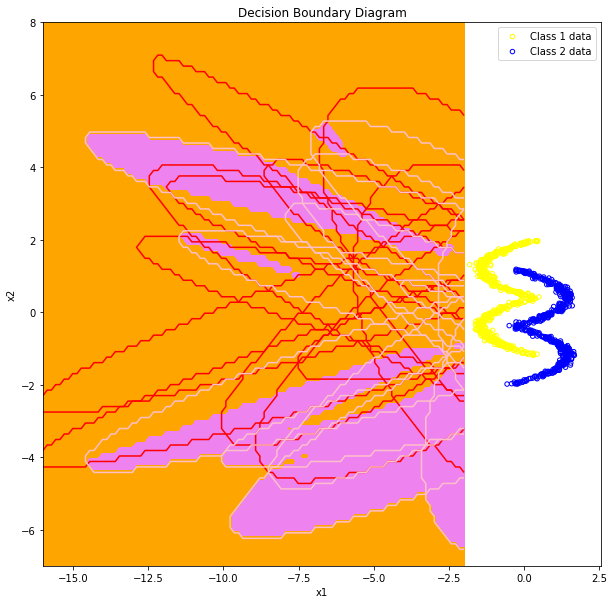

In [13]:
DecisionBoundaryPlotter([[-16,-2],[-7,8]], [gmm1.mu,gmm2.mu], [gmm1.sigma,gmm2.sigma], X_dev, Y_dev, classifier=classifier)

In [14]:
def measure_accuracy_syn(gmm1: GMM, gmm2: GMM, X_dev,Y_dev):
    accuracy = 0.
    for i in range(len(X_dev)):
        x = X_dev[i]
        s1 = gmm1.score(x)
        s2 = gmm2.score(x)
        if(s1 > s2):
            if(Y_dev[i] == 1):
                accuracy += 1
            else:
                accuracy -= 1
        elif(s2 > s1):
            if(Y_dev[i] == 2):
                accuracy += 1
            else:
                accuracy -= 1
        else:
            print("Ambigious point")
            # random
            r = np.random.randint(1,3)
            if(r == Y_dev[i]):
                accuracy += 1
            else:
                accuracy -= 1
    accuracy *= 100/len(X_dev)
    return accuracy

  0%|          | 0/7056 [00:00<?, ?it/s]

K MEANS CLUSTERING: k=16:   0%|          | 0/5 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/5 [00:00<?, ?it/s]

K MEANS CLUSTERING: k=16:   0%|          | 0/5 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/5 [00:00<?, ?it/s]

Accuracy =  98.2 %


K MEANS CLUSTERING: k=16:   0%|          | 0/5 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/5 [00:00<?, ?it/s]

K MEANS CLUSTERING: k=16:   0%|          | 0/5 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/5 [00:00<?, ?it/s]

Accuracy =  98.2 %


K MEANS CLUSTERING: k=16:   0%|          | 0/5 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/5 [00:00<?, ?it/s]

K MEANS CLUSTERING: k=16:   0%|          | 0/5 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/5 [00:00<?, ?it/s]

Accuracy =  98.2 %


K MEANS CLUSTERING: k=16:   0%|          | 0/5 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/5 [00:00<?, ?it/s]

K MEANS CLUSTERING: k=16:   0%|          | 0/5 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/5 [00:00<?, ?it/s]

Accuracy =  98.2 %


K MEANS CLUSTERING: k=16:   0%|          | 0/5 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/5 [00:00<?, ?it/s]

K MEANS CLUSTERING: k=16:   0%|          | 0/5 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/5 [00:00<?, ?it/s]

Accuracy =  98.2 %


K MEANS CLUSTERING: k=16:   0%|          | 0/5 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/5 [00:00<?, ?it/s]

K MEANS CLUSTERING: k=16:   0%|          | 0/5 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/5 [00:00<?, ?it/s]

Accuracy =  98.2 %


K MEANS CLUSTERING: k=16:   0%|          | 0/10 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/10 [00:00<?, ?it/s]

K MEANS CLUSTERING: k=16:   0%|          | 0/10 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/10 [00:00<?, ?it/s]

Accuracy =  100.0 %


K MEANS CLUSTERING: k=16:   0%|          | 0/10 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/10 [00:00<?, ?it/s]

K MEANS CLUSTERING: k=16:   0%|          | 0/10 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/10 [00:00<?, ?it/s]

Accuracy =  100.0 %


K MEANS CLUSTERING: k=16:   0%|          | 0/10 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/10 [00:00<?, ?it/s]

K MEANS CLUSTERING: k=16:   0%|          | 0/10 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/10 [00:00<?, ?it/s]

Accuracy =  100.0 %


K MEANS CLUSTERING: k=16:   0%|          | 0/10 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/10 [00:00<?, ?it/s]

K MEANS CLUSTERING: k=16:   0%|          | 0/10 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/10 [00:00<?, ?it/s]

Accuracy =  100.0 %


K MEANS CLUSTERING: k=16:   0%|          | 0/10 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/10 [00:00<?, ?it/s]

K MEANS CLUSTERING: k=16:   0%|          | 0/10 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/10 [00:00<?, ?it/s]

Accuracy =  100.0 %


K MEANS CLUSTERING: k=16:   0%|          | 0/10 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/10 [00:00<?, ?it/s]

K MEANS CLUSTERING: k=16:   0%|          | 0/10 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/10 [00:00<?, ?it/s]

Accuracy =  100.0 %


K MEANS CLUSTERING: k=16:   0%|          | 0/15 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/15 [00:00<?, ?it/s]

K MEANS CLUSTERING: k=16:   0%|          | 0/15 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/15 [00:00<?, ?it/s]

Accuracy =  100.0 %


K MEANS CLUSTERING: k=16:   0%|          | 0/15 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/15 [00:00<?, ?it/s]

K MEANS CLUSTERING: k=16:   0%|          | 0/15 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/15 [00:00<?, ?it/s]

Accuracy =  100.0 %


K MEANS CLUSTERING: k=16:   0%|          | 0/15 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/15 [00:00<?, ?it/s]

K MEANS CLUSTERING: k=16:   0%|          | 0/15 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/15 [00:00<?, ?it/s]

Accuracy =  100.0 %


K MEANS CLUSTERING: k=16:   0%|          | 0/15 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/15 [00:00<?, ?it/s]

K MEANS CLUSTERING: k=16:   0%|          | 0/15 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/15 [00:00<?, ?it/s]

Accuracy =  100.0 %


K MEANS CLUSTERING: k=16:   0%|          | 0/15 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/15 [00:00<?, ?it/s]

K MEANS CLUSTERING: k=16:   0%|          | 0/15 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/15 [00:00<?, ?it/s]

Accuracy =  100.0 %


K MEANS CLUSTERING: k=16:   0%|          | 0/15 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/15 [00:00<?, ?it/s]

K MEANS CLUSTERING: k=16:   0%|          | 0/15 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/15 [00:00<?, ?it/s]

Accuracy =  100.0 %


K MEANS CLUSTERING: k=16:   0%|          | 0/20 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/20 [00:00<?, ?it/s]

K MEANS CLUSTERING: k=16:   0%|          | 0/20 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/20 [00:00<?, ?it/s]

Accuracy =  100.0 %


K MEANS CLUSTERING: k=16:   0%|          | 0/20 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/20 [00:00<?, ?it/s]

K MEANS CLUSTERING: k=16:   0%|          | 0/20 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/20 [00:00<?, ?it/s]

Accuracy =  100.0 %


K MEANS CLUSTERING: k=16:   0%|          | 0/20 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/20 [00:00<?, ?it/s]

K MEANS CLUSTERING: k=16:   0%|          | 0/20 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/20 [00:00<?, ?it/s]

Accuracy =  100.0 %


K MEANS CLUSTERING: k=16:   0%|          | 0/20 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/20 [00:00<?, ?it/s]

K MEANS CLUSTERING: k=16:   0%|          | 0/20 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/20 [00:00<?, ?it/s]

Accuracy =  100.0 %


K MEANS CLUSTERING: k=16:   0%|          | 0/20 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/20 [00:00<?, ?it/s]

K MEANS CLUSTERING: k=16:   0%|          | 0/20 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/20 [00:00<?, ?it/s]

Accuracy =  100.0 %


K MEANS CLUSTERING: k=16:   0%|          | 0/20 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/20 [00:00<?, ?it/s]

K MEANS CLUSTERING: k=16:   0%|          | 0/20 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/20 [00:00<?, ?it/s]

Accuracy =  100.0 %


K MEANS CLUSTERING: k=16:   0%|          | 0/25 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/25 [00:00<?, ?it/s]

K MEANS CLUSTERING: k=16:   0%|          | 0/25 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/25 [00:00<?, ?it/s]

Accuracy =  100.0 %


K MEANS CLUSTERING: k=16:   0%|          | 0/25 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/25 [00:00<?, ?it/s]

K MEANS CLUSTERING: k=16:   0%|          | 0/25 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/25 [00:00<?, ?it/s]

Accuracy =  100.0 %


K MEANS CLUSTERING: k=16:   0%|          | 0/25 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/25 [00:00<?, ?it/s]

K MEANS CLUSTERING: k=16:   0%|          | 0/25 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/25 [00:00<?, ?it/s]

Accuracy =  100.0 %


K MEANS CLUSTERING: k=16:   0%|          | 0/25 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/25 [00:00<?, ?it/s]

K MEANS CLUSTERING: k=16:   0%|          | 0/25 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/25 [00:00<?, ?it/s]

Accuracy =  100.0 %


K MEANS CLUSTERING: k=16:   0%|          | 0/25 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/25 [00:00<?, ?it/s]

K MEANS CLUSTERING: k=16:   0%|          | 0/25 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/25 [00:00<?, ?it/s]

Accuracy =  100.0 %


K MEANS CLUSTERING: k=16:   0%|          | 0/25 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/25 [00:00<?, ?it/s]

K MEANS CLUSTERING: k=16:   0%|          | 0/25 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/25 [00:00<?, ?it/s]

Accuracy =  100.0 %


K MEANS CLUSTERING: k=16:   0%|          | 0/30 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/30 [00:00<?, ?it/s]

K MEANS CLUSTERING: k=16:   0%|          | 0/30 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/30 [00:00<?, ?it/s]

Accuracy =  100.0 %


K MEANS CLUSTERING: k=16:   0%|          | 0/30 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/30 [00:00<?, ?it/s]

K MEANS CLUSTERING: k=16:   0%|          | 0/30 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/30 [00:00<?, ?it/s]

Accuracy =  100.0 %


K MEANS CLUSTERING: k=16:   0%|          | 0/30 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/30 [00:00<?, ?it/s]

K MEANS CLUSTERING: k=16:   0%|          | 0/30 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/30 [00:00<?, ?it/s]

Accuracy =  100.0 %


K MEANS CLUSTERING: k=16:   0%|          | 0/30 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/30 [00:00<?, ?it/s]

K MEANS CLUSTERING: k=16:   0%|          | 0/30 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/30 [00:00<?, ?it/s]

Accuracy =  100.0 %


K MEANS CLUSTERING: k=16:   0%|          | 0/30 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/30 [00:00<?, ?it/s]

K MEANS CLUSTERING: k=16:   0%|          | 0/30 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/30 [00:00<?, ?it/s]

Accuracy =  100.0 %


K MEANS CLUSTERING: k=16:   0%|          | 0/30 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/30 [00:00<?, ?it/s]

K MEANS CLUSTERING: k=16:   0%|          | 0/30 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/30 [00:00<?, ?it/s]

Accuracy =  100.0 %


K MEANS CLUSTERING: k=16:   0%|          | 0/5 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/5 [00:00<?, ?it/s]

K MEANS CLUSTERING: k=15:   0%|          | 0/5 [00:00<?, ?it/s]

GMM (EM): k=15:   0%|          | 0/5 [00:00<?, ?it/s]

Accuracy =  98.2 %


K MEANS CLUSTERING: k=16:   0%|          | 0/5 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/5 [00:00<?, ?it/s]

K MEANS CLUSTERING: k=15:   0%|          | 0/5 [00:00<?, ?it/s]

GMM (EM): k=15:   0%|          | 0/5 [00:00<?, ?it/s]

Accuracy =  98.2 %


K MEANS CLUSTERING: k=16:   0%|          | 0/5 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/5 [00:00<?, ?it/s]

K MEANS CLUSTERING: k=15:   0%|          | 0/5 [00:00<?, ?it/s]

GMM (EM): k=15:   0%|          | 0/5 [00:00<?, ?it/s]

Accuracy =  98.2 %


K MEANS CLUSTERING: k=16:   0%|          | 0/5 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/5 [00:00<?, ?it/s]

K MEANS CLUSTERING: k=15:   0%|          | 0/5 [00:00<?, ?it/s]

GMM (EM): k=15:   0%|          | 0/5 [00:00<?, ?it/s]

Accuracy =  98.2 %


K MEANS CLUSTERING: k=16:   0%|          | 0/5 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/5 [00:00<?, ?it/s]

K MEANS CLUSTERING: k=15:   0%|          | 0/5 [00:00<?, ?it/s]

GMM (EM): k=15:   0%|          | 0/5 [00:00<?, ?it/s]

Accuracy =  98.2 %


K MEANS CLUSTERING: k=16:   0%|          | 0/5 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/5 [00:00<?, ?it/s]

K MEANS CLUSTERING: k=15:   0%|          | 0/5 [00:00<?, ?it/s]

GMM (EM): k=15:   0%|          | 0/5 [00:00<?, ?it/s]

Accuracy =  98.2 %


K MEANS CLUSTERING: k=16:   0%|          | 0/10 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/10 [00:00<?, ?it/s]

K MEANS CLUSTERING: k=15:   0%|          | 0/10 [00:00<?, ?it/s]

GMM (EM): k=15:   0%|          | 0/10 [00:00<?, ?it/s]

Accuracy =  100.0 %


K MEANS CLUSTERING: k=16:   0%|          | 0/10 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/10 [00:00<?, ?it/s]

K MEANS CLUSTERING: k=15:   0%|          | 0/10 [00:00<?, ?it/s]

GMM (EM): k=15:   0%|          | 0/10 [00:00<?, ?it/s]

Accuracy =  100.0 %


K MEANS CLUSTERING: k=16:   0%|          | 0/10 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/10 [00:00<?, ?it/s]

K MEANS CLUSTERING: k=15:   0%|          | 0/10 [00:00<?, ?it/s]

GMM (EM): k=15:   0%|          | 0/10 [00:00<?, ?it/s]

Accuracy =  100.0 %


K MEANS CLUSTERING: k=16:   0%|          | 0/10 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/10 [00:00<?, ?it/s]

K MEANS CLUSTERING: k=15:   0%|          | 0/10 [00:00<?, ?it/s]

GMM (EM): k=15:   0%|          | 0/10 [00:00<?, ?it/s]

Accuracy =  100.0 %


K MEANS CLUSTERING: k=16:   0%|          | 0/10 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/10 [00:00<?, ?it/s]

K MEANS CLUSTERING: k=15:   0%|          | 0/10 [00:00<?, ?it/s]

GMM (EM): k=15:   0%|          | 0/10 [00:00<?, ?it/s]

Accuracy =  100.0 %


K MEANS CLUSTERING: k=16:   0%|          | 0/10 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/10 [00:00<?, ?it/s]

K MEANS CLUSTERING: k=15:   0%|          | 0/10 [00:00<?, ?it/s]

GMM (EM): k=15:   0%|          | 0/10 [00:00<?, ?it/s]

Accuracy =  100.0 %


K MEANS CLUSTERING: k=16:   0%|          | 0/15 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/15 [00:00<?, ?it/s]

K MEANS CLUSTERING: k=15:   0%|          | 0/15 [00:00<?, ?it/s]

GMM (EM): k=15:   0%|          | 0/15 [00:00<?, ?it/s]

Accuracy =  100.0 %


K MEANS CLUSTERING: k=16:   0%|          | 0/15 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/15 [00:00<?, ?it/s]

K MEANS CLUSTERING: k=15:   0%|          | 0/15 [00:00<?, ?it/s]

GMM (EM): k=15:   0%|          | 0/15 [00:00<?, ?it/s]

Accuracy =  100.0 %


K MEANS CLUSTERING: k=16:   0%|          | 0/15 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/15 [00:00<?, ?it/s]

K MEANS CLUSTERING: k=15:   0%|          | 0/15 [00:00<?, ?it/s]

GMM (EM): k=15:   0%|          | 0/15 [00:00<?, ?it/s]

Accuracy =  100.0 %


K MEANS CLUSTERING: k=16:   0%|          | 0/15 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/15 [00:00<?, ?it/s]

K MEANS CLUSTERING: k=15:   0%|          | 0/15 [00:00<?, ?it/s]

GMM (EM): k=15:   0%|          | 0/15 [00:00<?, ?it/s]

Accuracy =  100.0 %


K MEANS CLUSTERING: k=16:   0%|          | 0/15 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/15 [00:00<?, ?it/s]

K MEANS CLUSTERING: k=15:   0%|          | 0/15 [00:00<?, ?it/s]

GMM (EM): k=15:   0%|          | 0/15 [00:00<?, ?it/s]

Accuracy =  100.0 %


K MEANS CLUSTERING: k=16:   0%|          | 0/15 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/15 [00:00<?, ?it/s]

K MEANS CLUSTERING: k=15:   0%|          | 0/15 [00:00<?, ?it/s]

GMM (EM): k=15:   0%|          | 0/15 [00:00<?, ?it/s]

Accuracy =  100.0 %


K MEANS CLUSTERING: k=16:   0%|          | 0/20 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/20 [00:00<?, ?it/s]

K MEANS CLUSTERING: k=15:   0%|          | 0/20 [00:00<?, ?it/s]

GMM (EM): k=15:   0%|          | 0/20 [00:00<?, ?it/s]

Accuracy =  100.0 %


K MEANS CLUSTERING: k=16:   0%|          | 0/20 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/20 [00:00<?, ?it/s]

K MEANS CLUSTERING: k=15:   0%|          | 0/20 [00:00<?, ?it/s]

GMM (EM): k=15:   0%|          | 0/20 [00:00<?, ?it/s]

Accuracy =  100.0 %


K MEANS CLUSTERING: k=16:   0%|          | 0/20 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/20 [00:00<?, ?it/s]

K MEANS CLUSTERING: k=15:   0%|          | 0/20 [00:00<?, ?it/s]

GMM (EM): k=15:   0%|          | 0/20 [00:00<?, ?it/s]

Accuracy =  100.0 %


K MEANS CLUSTERING: k=16:   0%|          | 0/20 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/20 [00:00<?, ?it/s]

K MEANS CLUSTERING: k=15:   0%|          | 0/20 [00:00<?, ?it/s]

GMM (EM): k=15:   0%|          | 0/20 [00:00<?, ?it/s]

Accuracy =  100.0 %


K MEANS CLUSTERING: k=16:   0%|          | 0/20 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/20 [00:00<?, ?it/s]

K MEANS CLUSTERING: k=15:   0%|          | 0/20 [00:00<?, ?it/s]

GMM (EM): k=15:   0%|          | 0/20 [00:00<?, ?it/s]

Accuracy =  100.0 %


K MEANS CLUSTERING: k=16:   0%|          | 0/20 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/20 [00:00<?, ?it/s]

K MEANS CLUSTERING: k=15:   0%|          | 0/20 [00:00<?, ?it/s]

GMM (EM): k=15:   0%|          | 0/20 [00:00<?, ?it/s]

Accuracy =  100.0 %


K MEANS CLUSTERING: k=16:   0%|          | 0/25 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/25 [00:00<?, ?it/s]

K MEANS CLUSTERING: k=15:   0%|          | 0/25 [00:00<?, ?it/s]

GMM (EM): k=15:   0%|          | 0/25 [00:00<?, ?it/s]

Accuracy =  100.0 %


K MEANS CLUSTERING: k=16:   0%|          | 0/25 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/25 [00:00<?, ?it/s]

K MEANS CLUSTERING: k=15:   0%|          | 0/25 [00:00<?, ?it/s]

GMM (EM): k=15:   0%|          | 0/25 [00:00<?, ?it/s]

Accuracy =  100.0 %


K MEANS CLUSTERING: k=16:   0%|          | 0/25 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/25 [00:00<?, ?it/s]

K MEANS CLUSTERING: k=15:   0%|          | 0/25 [00:00<?, ?it/s]

GMM (EM): k=15:   0%|          | 0/25 [00:00<?, ?it/s]

Accuracy =  100.0 %


K MEANS CLUSTERING: k=16:   0%|          | 0/25 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/25 [00:00<?, ?it/s]

K MEANS CLUSTERING: k=15:   0%|          | 0/25 [00:00<?, ?it/s]

GMM (EM): k=15:   0%|          | 0/25 [00:00<?, ?it/s]

Accuracy =  100.0 %


K MEANS CLUSTERING: k=16:   0%|          | 0/25 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/25 [00:00<?, ?it/s]

K MEANS CLUSTERING: k=15:   0%|          | 0/25 [00:00<?, ?it/s]

GMM (EM): k=15:   0%|          | 0/25 [00:00<?, ?it/s]

Accuracy =  100.0 %


K MEANS CLUSTERING: k=16:   0%|          | 0/25 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/25 [00:00<?, ?it/s]

K MEANS CLUSTERING: k=15:   0%|          | 0/25 [00:00<?, ?it/s]

GMM (EM): k=15:   0%|          | 0/25 [00:00<?, ?it/s]

Accuracy =  100.0 %


K MEANS CLUSTERING: k=16:   0%|          | 0/30 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/30 [00:00<?, ?it/s]

K MEANS CLUSTERING: k=15:   0%|          | 0/30 [00:00<?, ?it/s]

GMM (EM): k=15:   0%|          | 0/30 [00:00<?, ?it/s]

Accuracy =  100.0 %


K MEANS CLUSTERING: k=16:   0%|          | 0/30 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/30 [00:00<?, ?it/s]

K MEANS CLUSTERING: k=15:   0%|          | 0/30 [00:00<?, ?it/s]

GMM (EM): k=15:   0%|          | 0/30 [00:00<?, ?it/s]

Accuracy =  100.0 %


K MEANS CLUSTERING: k=16:   0%|          | 0/30 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/30 [00:00<?, ?it/s]

K MEANS CLUSTERING: k=15:   0%|          | 0/30 [00:00<?, ?it/s]

GMM (EM): k=15:   0%|          | 0/30 [00:00<?, ?it/s]

Accuracy =  100.0 %


K MEANS CLUSTERING: k=16:   0%|          | 0/30 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/30 [00:00<?, ?it/s]

K MEANS CLUSTERING: k=15:   0%|          | 0/30 [00:00<?, ?it/s]

GMM (EM): k=15:   0%|          | 0/30 [00:00<?, ?it/s]

Accuracy =  100.0 %


K MEANS CLUSTERING: k=16:   0%|          | 0/30 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/30 [00:00<?, ?it/s]

K MEANS CLUSTERING: k=15:   0%|          | 0/30 [00:00<?, ?it/s]

GMM (EM): k=15:   0%|          | 0/30 [00:00<?, ?it/s]

Accuracy =  100.0 %


K MEANS CLUSTERING: k=16:   0%|          | 0/30 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/30 [00:00<?, ?it/s]

K MEANS CLUSTERING: k=15:   0%|          | 0/30 [00:00<?, ?it/s]

GMM (EM): k=15:   0%|          | 0/30 [00:00<?, ?it/s]

Accuracy =  100.0 %


K MEANS CLUSTERING: k=16:   0%|          | 0/5 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/5 [00:00<?, ?it/s]

K MEANS CLUSTERING: k=14:   0%|          | 0/5 [00:00<?, ?it/s]

GMM (EM): k=14:   0%|          | 0/5 [00:00<?, ?it/s]

Accuracy =  98.0 %


K MEANS CLUSTERING: k=16:   0%|          | 0/5 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/5 [00:00<?, ?it/s]

K MEANS CLUSTERING: k=14:   0%|          | 0/5 [00:00<?, ?it/s]

GMM (EM): k=14:   0%|          | 0/5 [00:00<?, ?it/s]

Accuracy =  98.0 %


K MEANS CLUSTERING: k=16:   0%|          | 0/5 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/5 [00:00<?, ?it/s]

K MEANS CLUSTERING: k=14:   0%|          | 0/5 [00:00<?, ?it/s]

GMM (EM): k=14:   0%|          | 0/5 [00:00<?, ?it/s]

Accuracy =  98.0 %


K MEANS CLUSTERING: k=16:   0%|          | 0/5 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/5 [00:00<?, ?it/s]

K MEANS CLUSTERING: k=14:   0%|          | 0/5 [00:00<?, ?it/s]

GMM (EM): k=14:   0%|          | 0/5 [00:00<?, ?it/s]

Accuracy =  98.0 %


K MEANS CLUSTERING: k=16:   0%|          | 0/5 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/5 [00:00<?, ?it/s]

K MEANS CLUSTERING: k=14:   0%|          | 0/5 [00:00<?, ?it/s]

GMM (EM): k=14:   0%|          | 0/5 [00:00<?, ?it/s]

Accuracy =  98.0 %


K MEANS CLUSTERING: k=16:   0%|          | 0/5 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/5 [00:00<?, ?it/s]

K MEANS CLUSTERING: k=14:   0%|          | 0/5 [00:00<?, ?it/s]

GMM (EM): k=14:   0%|          | 0/5 [00:00<?, ?it/s]

Accuracy =  98.0 %


K MEANS CLUSTERING: k=16:   0%|          | 0/10 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/10 [00:00<?, ?it/s]

K MEANS CLUSTERING: k=14:   0%|          | 0/10 [00:00<?, ?it/s]

GMM (EM): k=14:   0%|          | 0/10 [00:00<?, ?it/s]

Accuracy =  100.0 %


K MEANS CLUSTERING: k=16:   0%|          | 0/10 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/10 [00:00<?, ?it/s]

K MEANS CLUSTERING: k=14:   0%|          | 0/10 [00:00<?, ?it/s]

GMM (EM): k=14:   0%|          | 0/10 [00:00<?, ?it/s]

Accuracy =  100.0 %


K MEANS CLUSTERING: k=16:   0%|          | 0/10 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/10 [00:00<?, ?it/s]

K MEANS CLUSTERING: k=14:   0%|          | 0/10 [00:00<?, ?it/s]

GMM (EM): k=14:   0%|          | 0/10 [00:00<?, ?it/s]

Accuracy =  100.0 %


K MEANS CLUSTERING: k=16:   0%|          | 0/10 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/10 [00:00<?, ?it/s]

K MEANS CLUSTERING: k=14:   0%|          | 0/10 [00:00<?, ?it/s]

GMM (EM): k=14:   0%|          | 0/10 [00:00<?, ?it/s]

Accuracy =  100.0 %


K MEANS CLUSTERING: k=16:   0%|          | 0/10 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/10 [00:00<?, ?it/s]

K MEANS CLUSTERING: k=14:   0%|          | 0/10 [00:00<?, ?it/s]

GMM (EM): k=14:   0%|          | 0/10 [00:00<?, ?it/s]

Accuracy =  100.0 %


K MEANS CLUSTERING: k=16:   0%|          | 0/10 [00:00<?, ?it/s]

GMM (EM): k=16:   0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [21]:
print (good)

[[16, 16, 10, 5], [16, 16, 10, 10], [16, 16, 10, 15], [16, 16, 10, 20], [16, 16, 10, 25], [16, 16, 10, 30], [16, 16, 15, 5], [16, 16, 15, 10], [16, 16, 15, 15], [16, 16, 15, 20], [16, 16, 15, 25], [16, 16, 15, 30], [16, 16, 20, 5], [16, 16, 20, 10], [16, 16, 20, 15], [16, 16, 20, 20], [16, 16, 20, 25], [16, 16, 20, 30], [16, 16, 25, 5], [16, 16, 25, 10], [16, 16, 25, 15], [16, 16, 25, 20], [16, 16, 25, 25], [16, 16, 25, 30], [16, 16, 30, 5], [16, 16, 30, 10], [16, 16, 30, 15], [16, 16, 30, 20], [16, 16, 30, 25], [16, 16, 30, 30], [16, 15, 10, 5], [16, 15, 10, 10], [16, 15, 10, 15], [16, 15, 10, 20], [16, 15, 10, 25], [16, 15, 10, 30], [16, 15, 15, 5], [16, 15, 15, 10], [16, 15, 15, 15], [16, 15, 15, 20], [16, 15, 15, 25], [16, 15, 15, 30], [16, 15, 20, 5], [16, 15, 20, 10], [16, 15, 20, 15], [16, 15, 20, 20], [16, 15, 20, 25], [16, 15, 20, 30], [16, 15, 25, 5], [16, 15, 25, 10], [16, 15, 25, 15], [16, 15, 25, 20], [16, 15, 25, 25], [16, 15, 25, 30], [16, 15, 30, 5], [16, 15, 30, 10], [